# Building Explainable Machine Learning Models

## Explaining models with LIME

LIME stands for `Local Interpretable Model-Agnostic Explanations` 
It generates an explanation by approximating the underlying model by an interpretable one.

# Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [1]:
import os
import numpy as np   
import pandas as pd  

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
import gc
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# For image manipulations
from PIL import Image
import skimage
from skimage.io import imread

np.random.seed(123) #ensure reproducibility
RANDOM_STATE = 42

## Model Interpretation package
import lime
from lime import lime_tabular
from lime import lime_text
from lime import lime_image

import warnings  
warnings.filterwarnings("ignore")

In [2]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, rc={"figure.figsize":(10,6)})

## Case Study - Image Dataset

### Husky(Dog) or Wolf?
We want to explain a classifier that predicts whether the given image is of a husky or a wolf.

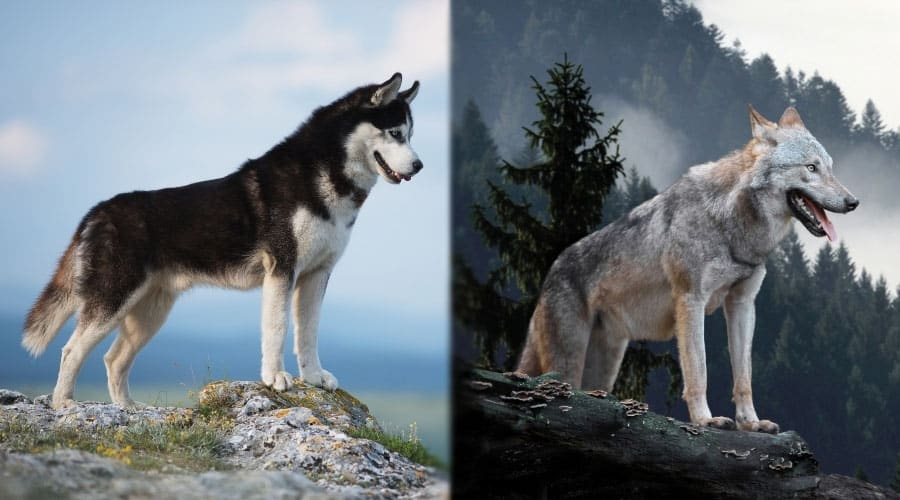

In [3]:
Image.open('husky_or_wolf.jpg')

### Training Dataset

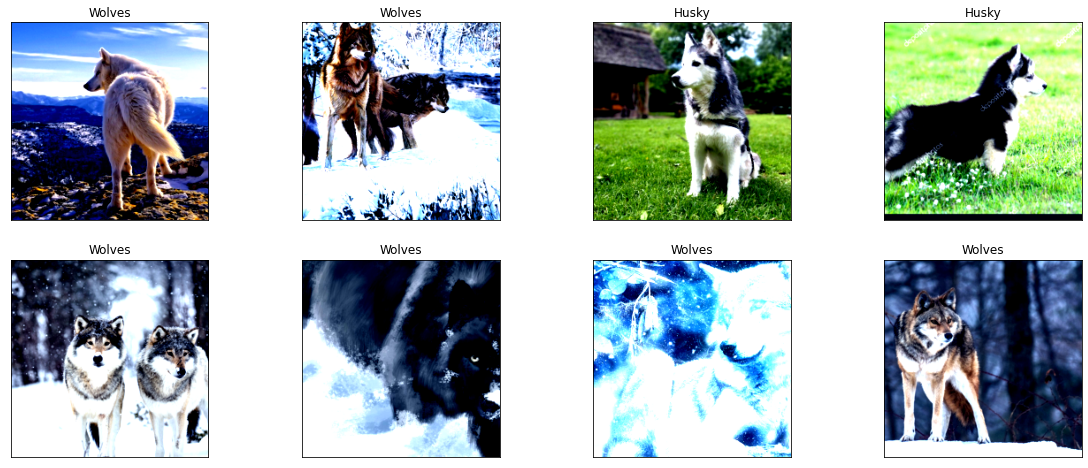

In [4]:
Image.open('training_set.png')

We'll take the image and divide it into interpretable components (contiguous superpixels).

In [5]:
classes = dict({0: 'Husky', 1: 'Wolf'})

## Reading and preprocessing the test image

We will resize and preprocess the image.

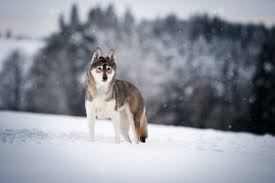

In [6]:
test_img = Image.open('husky.jpg').convert('RGB')
test_img

We will define two separate transforms:
* (1) to take PIL image, resize and crop it 
* (2) take resized, cropped image and apply whitening.

In [7]:
# resize and take the center part of image to what our model expects
#source: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

## Loading the pretrained Pytorch model

We are going to use the pre-trained model.

In [8]:
#Download the model from https://drive.google.com/drive/folders/1w-FS2GU4_f-scDFLT4h6nmj7enuxoz2z?usp=sharing and place it in model folder.

model = torch.load('black_box_model', map_location=torch.device('cpu'))

## Predicting the class of the input Image

In [9]:
#source: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(test_img)])
test_pred.squeeze().argmax()

1

## Explaining predictions with LIME Image

The model predicts that the the probability for the given images to be a Wolf. Let's now understand why the model thinks it to be a wolf and not husky. We'll use Lime to generate explanations for us.

* Generate random perturbations for input image by turning on and off some of the super-pixels in the image.
* Use a classifier to predict classes of new generated images
* Calculate distances between the original image and each of the perturbed images and compute the weights (importance) of each perturbed image
* Use perturbations, predictions and weights to fit an explainable (linear) model
* Calculate the top superpixels

In [11]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [12]:
explanation = explainer.explain_instance(np.array(pill_transf(test_img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classifier

  0%|          | 0/1000 [00:00<?, ?it/s]

## Visualizing the Explanations

We can see the top 10 superpixels that are most positive towards the class

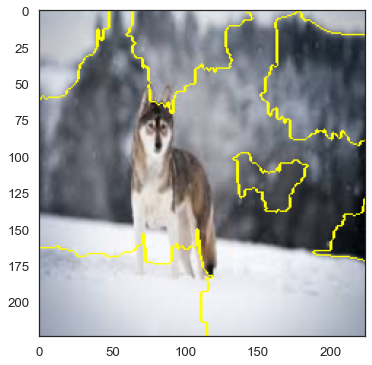

In [13]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

* the rest of the image hidden

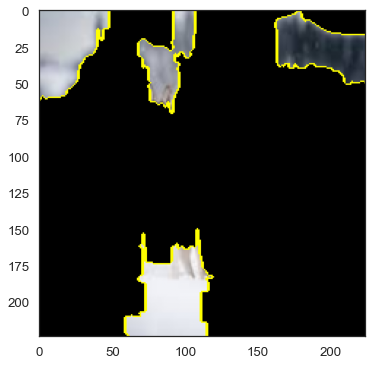

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)